# Nuclei segmentation using Cellpose

In this tutorial we show how we can use the anatomical segmentation algorithm Cellpose in `squidpy.im.segment` for nuclei segmentation.

**Cellpose** <cite data-cite="cellpose">Stringer, Carsen, et al. (2021)</cite>, ([code](https://github.com/MouseLand/cellpose)) is a novel anatomical segmentation algorithm. To use it in this example, we need to install it first via: `pip install cellpose`.
To run the notebook locally, create a conda environment as *conda env create -f cellpose_environment.yml* using this [cellpose_environment.yml](https://github.com/theislab/squidpy_notebooks/blob/master/envs/cellpose_environment.yml), which installs Squidpy and Cellpose.

In [1]:
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt

## Prepare custom segmentation function using Cellpose

Import the Cellpose segmentation model. See https://cellpose.readthedocs.io/en/latest/api.html#cellpose-class.

In [2]:
from cellpose import models

The method parameter of the `sq.im.segment` method accepts any callable with the signature:
`numpy.ndarray` (height, width, channels) -> `numpy.ndarray` (height, width[, channels]).
Additional model specific arguments will also be passed on.
To use the Cellpose model, we define a wrapper that initializes the model, evaluates it and returns the
segmentation masks. We can make use of Cellpose specific options by passing on arguments like the minimum
number of pixels per mask `min_size`.

In [3]:
def cellpose(img, min_size=15):
    model = models.Cellpose(model_type='nuclei')
    res, _, _, _ = model.eval(
        img, 
        channels=[0, 0], 
        diameter=None, 
        min_size=min_size,
    )
    return res

## Cell segmentation on Visium fluorescence data

Load the image and visualize its channels.

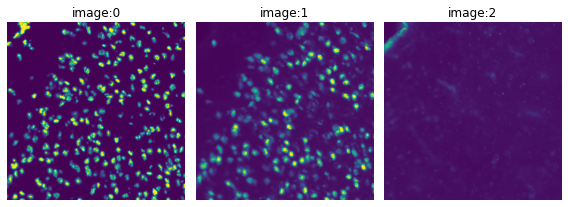

In [4]:
img = sq.datasets.visium_fluo_image_crop()
crop = img.crop_corner(1000, 1000, size=1000)
crop.show(channelwise=True)

Segment the DAPI channel using the `cellpose` function defined above.

In [5]:
sq.im.segment(img=crop, layer="image", channel=0, method=cellpose)

Plot the DAPI channel of the image crop and the segmentation result.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 334


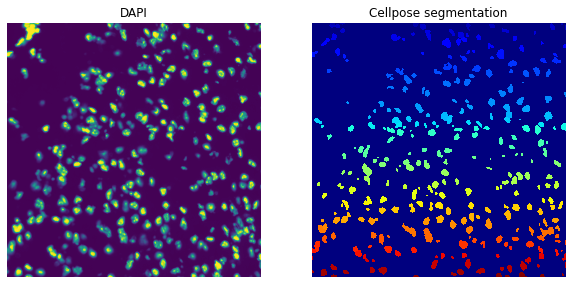

In [6]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

The `sq.im.segment` method will pass any additional arguments to the `cellpose` function, 
so we can also filter out segments with less than 200 pixels and compare the results to the
segmentation result from above that works with the default of 15 pixels.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 188


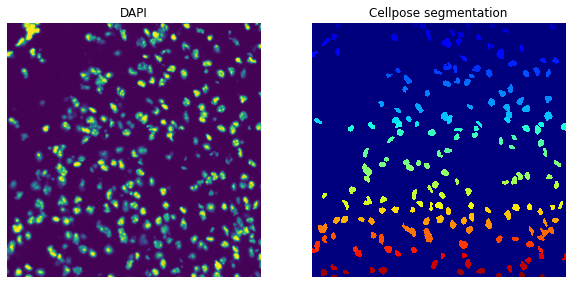

In [7]:
sq.im.segment(img=crop, layer="image", channel=0, method=cellpose, min_size=200)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

## Cell segmentation on H&E stained tissue data

For the fluorescence data, we did nuclei segmentation on the DAPI channel simply by just passing on that channel to the Cellpose model. For the H&E images, we will pass on all three channels by calling `sq.im.segment()` with `channel=None` and then decide in the Cellpose model on which channel we want to segment using the first element of the `channels` parameter. Here, we need to be cautious as the numbering is different (0=grayscale, 1=red, 2=green, 3=blue)!

Further, for H&E images we need to invert the color values by setting `invert=True`.
Additionally, we found that the naive usage will recognize only few of the cells and extended the arguments we
allow for Cellpose by `flow_threshold`.

In [8]:
def cellpose_he(img, min_size=15, flow_threshold=0.4, channel_cellpose=0):
    model = models.Cellpose(model_type='nuclei')
    res, _, _, _ = model.eval(
        img, 
        channels=[channel_cellpose, 0], 
        diameter=None, 
        min_size=min_size,
        invert=True,
        flow_threshold=flow_threshold,
    )
    return res

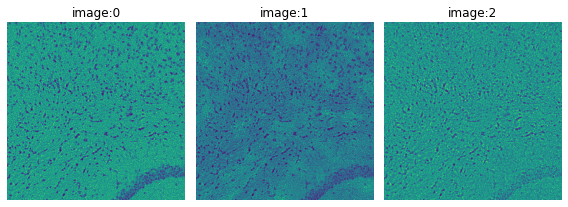

In [9]:
img = sq.datasets.visium_hne_image_crop()
crop = img.crop_corner(0, 0, size=1000)
crop.show("image", channelwise=True)

For the H&E image we start by testing the segmentation on only the blue channel (image:0).

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 647


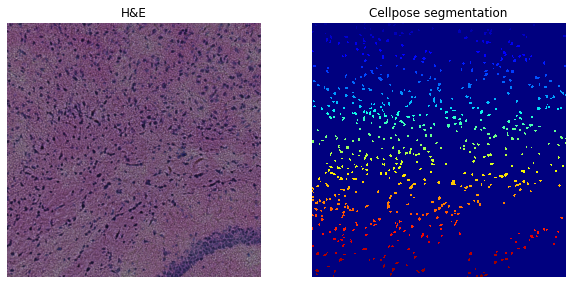

In [10]:
sq.im.segment(img=crop, layer="image", channel=None, method=cellpose_he, channel_cellpose=1)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=None, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

We clearly see that we should increase sensitivity and test `flow_threshold=0.8` resulting in significantly more detected nuclei.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 902


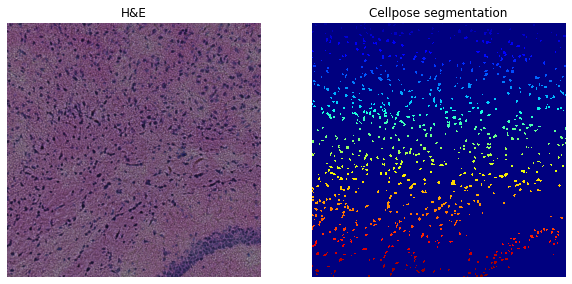

In [11]:
sq.im.segment(img=crop, layer="image", channel=None, method=cellpose_he, flow_threshold=0.8, channel_cellpose=1)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=None, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

We can also check whether using all channels improves nuclei detection by segmenting on the grayscale image (`channel_cellpose=0`).

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 449


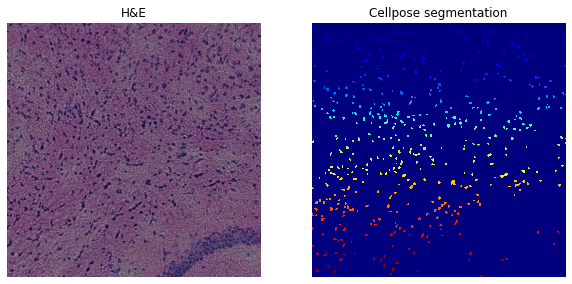

In [12]:
sq.im.segment(img=crop, layer="image", channel=None, method=cellpose_he, channel_cellpose=0)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=None, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")

And again with increased `flow_threshold=0.8`.

ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_custom']]
Number of segments in crop: 689


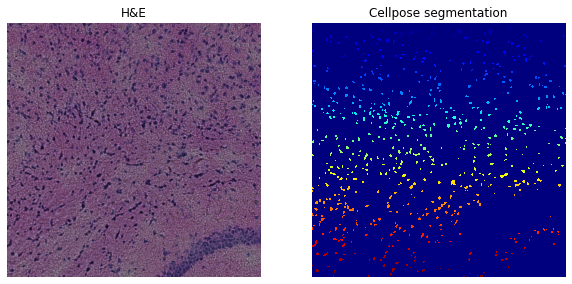

In [13]:
sq.im.segment(img=crop, layer="image", channel=None, method=cellpose_he, flow_threshold=0.8, channel_cellpose=0)

print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_custom']))}")

fig, axes = plt.subplots(1, 2, figsize=(10, 20))
crop.show("image", channel=None, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_custom", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("Cellpose segmentation")